# Vancouver Airbnb Data Analysis

### In this notebook I aim at answering three main questions. 

**1) What is the distribution of listings in a city and which areas have densely distributed listings?**

**2) Identifying important amenities affecting the price of a particular listing?**

**3) Which are most important amenities for setting the price of a particular listing?**


## 1. Loading Libraries and Data

In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
from scipy import stats


from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.metrics

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# Load data
listing_df = pd.read_csv('listings.csv')

In [3]:
# Looking at the head of the data
listing_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,13188,https://www.airbnb.com/rooms/13188,20180710033411,2018-07-10,Great private studio in ideal loc.,Private and modern studio suite (with garden p...,Explore Vancouver from your private and modern...,Private and modern studio suite (with garden p...,none,NaN,...,t,NaN,NaN,f,f,moderate,f,f,2,1.38
1,13364,https://www.airbnb.com/rooms/13364,20180710033411,2018-07-10,Christmas in Vancouver,CHRISTMAS IN VANCOUVER - million dollar view 1...,Maximum occupancy is 2 and this is a beautiful...,CHRISTMAS IN VANCOUVER - million dollar view 1...,none,The best of everything is within walking dista...,...,t,NaN,NaN,t,f,flexible,f,f,1,NaN
2,13490,https://www.airbnb.com/rooms/13490,20180710033411,2018-07-10,Vancouver's best kept secret,"In the heart of Vancouver, this apartment has ...","Vancouver city central, 700 sq.ft., main floor...","In the heart of Vancouver, this apartment has ...",none,"In the heart of Vancouver, this apartment has ...",...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,0.90
3,13537,https://www.airbnb.com/rooms/13537,20180710033411,2018-07-10,Beautiful 1 bdrm avail,NaN,Excellent apartment available for February 201...,Excellent apartment available for February 201...,none,NaN,...,t,NaN,NaN,f,f,strict_14_with_grace_period,f,f,1,NaN
4,14031,https://www.airbnb.com/rooms/14031,20180710033411,2018-07-10,House off Main,"Comfortable, beautiful, open concept Character...","Top floor is a very large bedroom, bathroom an...","Comfortable, beautiful, open concept Character...",none,"Lovely quiet, safe tree lined street with ever...",...,t,NaN,NaN,f,f,moderate,f,f,1,0.24


In [4]:
# Overall shape of the data
n, m = listing_df.shape
print('Number of observations:',n)
print('Number of features:',m)

Number of observations: 6437
Number of features: 96


## 2. Data cleaning

In [5]:
# Keep the columns which can affect the price of a home
columns_to_keep = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                   'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 
                   'host_identity_verified', 'neighbourhood_cleansed', 'reviews_per_month',
                   'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 
                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
                   'square_feet', 'price', 'security_deposit','cleaning_fee', 'guests_included',
                   'extra_people', 'minimum_nights', 'maximum_nights', 'availability_365', 
                   'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                   'review_scores_location', 'review_scores_value', 'requires_license', 'license', 
                   'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 
                   'require_guest_phone_verification', 'calculated_host_listings_count']

In [6]:
# Make a new data frame with only the important columns
listing_df = listing_df[columns_to_keep]

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
missing = listing_df.isnull().sum()
missing = missing[missing > 0]/(listing_df.shape[0]) * 100
missing.sort_values(inplace=True)

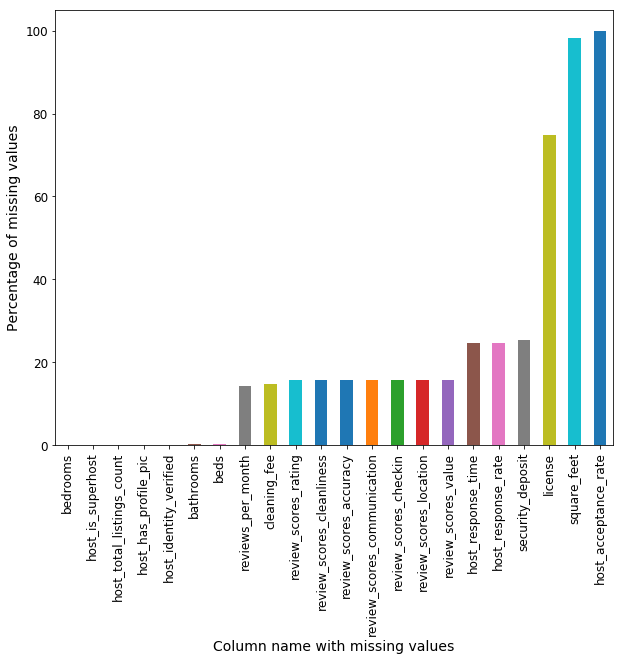

There are 22 columns with missing values.


In [8]:
missing.plot.bar(figsize=(10,8))
plt.xlabel('Column name with missing values')
plt.ylabel('Percentage of missing values')

plt.show()
print("There are {} columns with missing values.".format(len(missing)))

>We remove the columns with more than 20% missing values.

In [9]:
# Remove the columns with more than 20% missing values
for i, col in enumerate(missing.index):
    if missing[i] > 20:
        listing_df.drop(columns=col, inplace=True)

In [10]:
# How many features are there of each data type?
dtype={}
for data_type in listing_df.dtypes:
    if data_type not in dtype:
        dtype[data_type] = 1
    else:
        dtype[data_type] += 1
    
dtype

{dtype('O'): 17, dtype('float64'): 14, dtype('int64'): 7}

>We create a data frame with all the features that we would keep in our analysis. Firstly, we add all numeric columns. we deal with the Object columns in the following sections.

In [11]:
df_new = listing_df.select_dtypes(exclude=['O'])
df_new.head()

,host_total_listings_count,reviews_per_month,latitude,longitude,accommodates,bathrooms,bedrooms,beds,guests_included,minimum_nights,...,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count
0,2.0,1.38,49.245770,-123.105158,4,1.0,0.0,2.0,2,2,...,270,141,96.0,10.0,10.0,10.0,10.0,10.0,10.0,2
1,1.0,NaN,49.280043,-123.126853,2,1.0,1.0,1.0,1,3,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,4.0,0.90,49.255501,-123.066955,2,1.0,1.0,1.0,1,3,...,277,78,98.0,10.0,10.0,10.0,10.0,9.0,10.0,1
3,1.0,NaN,49.242791,-123.100753,2,NaN,NaN,1.0,1,4,...,365,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
4,1.0,0.24,49.238226,-123.100033,3,1.0,1.0,3.0,2,14,...,359,14,89.0,9.0,10.0,10.0,9.0,10.0,9.0,1


>We use median to fill in the missing values for numeric columns.

In [12]:
# Filling missing value of numeric columns; Object columns need to be processed before filling their missing values.
df_new.fillna(df_new.median(), inplace=True)

In [13]:
object_columns = listing_df.select_dtypes(include=['O'])
object_columns.head()

,host_is_superhost,host_has_profile_pic,host_identity_verified,neighbourhood_cleansed,is_location_exact,property_type,room_type,bed_type,amenities,price,cleaning_fee,extra_people,requires_license,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification
0,f,t,t,Riley Park,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,Kitchen,""Free par...",$110.00,$40.00,$0.00,t,f,moderate,f,f
1,f,t,f,Downtown,t,Condominium,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Air conditioning...",$151.00,NaN,$0.00,t,t,flexible,f,f
2,t,t,f,Kensington-Cedar Cottage,t,Apartment,Entire home/apt,Real Bed,"{TV,""Cable TV"",Internet,Wifi,""Wheelchair acces...",$145.00,$40.00,$0.00,t,f,strict_14_with_grace_period,f,f
3,f,t,f,Riley Park,t,Apartment,Entire home/apt,Real Bed,"{TV,Wifi,Kitchen,Heating}",$426.00,NaN,$0.00,t,f,strict_14_with_grace_period,f,f
4,f,t,f,Riley Park,t,House,Entire home/apt,Real Bed,"{TV,Internet,Wifi,Kitchen,""Free parking on pre...",$249.00,$140.00,$20.00,t,f,moderate,f,f


In [14]:
# True or False columns
bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy', 
                'require_guest_phone_verification', 'host_has_profile_pic','is_location_exact', 'requires_license',
                'instant_bookable'  ]
for col in bool_columns:
    df_new[col] = listing_df[col].map(lambda s: False if s == "f" else True)



In [15]:
# Filling missing values of boolean columns with median
for col in bool_columns:
    df_new[col] = df_new[col].fillna(df_new[col].median()) 

In [16]:
# Getting dummy variables of categorical features
categorical_columns = ['neighbourhood_cleansed', 'property_type', 
                       'room_type', 'bed_type','cancellation_policy']
for col in categorical_columns:
    df_new = pd.concat([df_new, pd.get_dummies(listing_df[col])], axis=1)

**Parsing amenities column**: The values are strings of various amenities of Airbnb homes which are comma separated. There are other special characters which needed to be removed. Once we remove the unnecessary characters we will create a list of all available amenities across all rows. The next step is to check every row and encode presence or absence of the amenities by 1 and 0. Finally we will concatenate all the columns to the existing features data frame.**[1]**

In [17]:
# removing unnecessary characters from amenities
amenities = np.array(listing_df['amenities'].map(lambda amns: amns.replace('"',"").replace('{',"").replace('}',"").split(',')))
# Create an array of all unique amenities across all rows
all_amenities = np.unique(np.concatenate(amenities))[1:]

In [18]:
def available_amenties(all_amenities, amenities):
    amenties_bool = np.empty((amenities.shape[0], all_amenities.shape[0]))
    for i, row in enumerate(amenities):
        amns = all_amenities.copy()
        for j, amn in enumerate(amns):
            if amn in amenities[i]:
                amenties_bool[i,j] = True
            else:
                amenties_bool[i,j] = False
    return amenties_bool

amenities = available_amenties(all_amenities, amenities)

In [19]:
# Reset index of the train data frame and drop the old index
df_new = df_new.reset_index(drop=True)

In [20]:
# Combine the train data frame and the amenities data frame
df_new = pd.concat([df_new, pd.DataFrame(data=amenities, columns=all_amenities)], axis=1)

**Parsing price related columns**

In [21]:
# For extra_people and price we only parse the data and convert them to float
df_new['extra_people'] = np.array(listing_df['extra_people'].map(lambda exp: float(exp.replace('$',"").replace(',',""))))
df_new['price'] = np.array(listing_df['price'].map(lambda price: float(price.replace('$',"").replace(',',""))))

For cleaning_fee column, we need to convert everything to string, then parse and then fill the missing values with the average.

In [22]:
df_new['cleaning_fee'] = listing_df['cleaning_fee'].astype('str')

In [23]:
df_new['cleaning_fee'] = df_new['cleaning_fee'].map(lambda cfee: np.nan if cfee == 'nan' else float(cfee.replace('$',"").replace(',',"")))

In [24]:
df_new['cleaning_fee'] = df_new['cleaning_fee'].fillna(df_new['cleaning_fee'].mean())

**Create a cleaning function**
We put all the above codes together to make a function which returns a clean data frame with all the columns being converted to numeric values.

In [25]:
def cleaning_dataframe(filename='listings.csv'):
    """
    Cleans the input, parses string columns, converts string to numbers, imputes missing values,
    removes the columns with too many missing values

    Parameters
    ----------
    filename : CSV file
        Messy csv file
        
    Returns
    -------
    df : Pandas dataframe
        Clean dataframe

    """
    df = pd.read_csv(filename)
    # Keep the columns which can affect the price of an Airbnb
    columns_to_keep = ['host_response_time', 'host_response_rate', 'host_acceptance_rate',
                   'host_is_superhost', 'host_total_listings_count', 'host_has_profile_pic', 
                   'host_identity_verified', 'neighbourhood_cleansed', 'reviews_per_month',
                   'latitude', 'longitude', 'is_location_exact', 'property_type', 'room_type', 
                   'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 
                   'square_feet', 'price', 'security_deposit','cleaning_fee', 'guests_included',
                   'extra_people', 'minimum_nights', 'maximum_nights', 'availability_365', 
                   'number_of_reviews', 'review_scores_rating', 'review_scores_accuracy', 
                   'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication',
                   'review_scores_location', 'review_scores_value', 'requires_license', 'license', 
                   'instant_bookable', 'cancellation_policy', 'require_guest_profile_picture', 
                   'require_guest_phone_verification', 'calculated_host_listings_count']
    
    # Make a new data frame with only the important columns
    df = df[columns_to_keep]
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    missing = df.isnull().sum()
    missing = missing[missing > 0]/(df.shape[0]) * 100
    missing.sort_values(inplace=True)
  
    # Remove the columns with more than 20% missing values
    for i, col in enumerate(missing.index):
        if missing[i] > 20:
            df.drop(columns=col, inplace=True)
            
    df_new = df.select_dtypes(exclude=['O'])
    
    # Filling missing values of numeric columns; Object columns need to be proccessed before filling their missing values.
    df_new.fillna(df_new.median(), inplace=True)
    
    # True or False columns
    bool_columns = ['host_is_superhost', 'host_has_profile_pic', 'host_identity_verified', 'cancellation_policy', 
                'require_guest_phone_verification', 'host_has_profile_pic','is_location_exact', 'requires_license',
                'instant_bookable']
    
    for col in bool_columns:
        df_new[col] = df[col].map(lambda s: 0 if s == "f" else 1)
        
    # Filling missing values of boolean columns with median
    for col in bool_columns:
        df_new[col] = df_new[col].fillna(df_new[col].median())
        
    # Getting dummy variables of categorical features
    categorical_columns = ['neighbourhood_cleansed', 'property_type', 
                       'room_type', 'bed_type','cancellation_policy']
    for col in categorical_columns:
        df_new = pd.concat([df_new, pd.get_dummies(df[col])], axis=1)
        
    # removing unnecessary characters from amenities
    amenities = np.array(df['amenities'].map(lambda amns: amns.replace('"',"").replace('{',"").replace('}',"").split(',')))
    
    # Create an array of all unique amenties accross all rows
    all_amenities = np.unique(np.concatenate(amenities))[1:]
    
    # Create amenities dataframe
    amenities = available_amenties(all_amenities, amenities)
    
    # Reset index of the train data frame and drop the old index
    df_new = df_new.reset_index(drop=True)

    # Combine the train data frame and the amenities data frame
    df_new = pd.concat([df_new, pd.DataFrame(data=amenities, columns=all_amenities)], axis=1)
    
    # Convert to string, parse and fill na values with average
    df_new['cleaning_fee'] = df['cleaning_fee'].astype('str')
    df_new['cleaning_fee'] = df_new['cleaning_fee'].map(lambda cfee: np.nan if cfee == 'nan' else float(cfee.replace('$',"").replace(',',"")))
    df_new['cleaning_fee'] = df_new['cleaning_fee'].fillna(df_new['cleaning_fee'].mean())
    
    # Parse the data and convert them to float
    df_new['extra_people'] = np.array(df['extra_people'].map(lambda exp: float(exp.replace('$',"").replace(',',""))))
    df_new['price'] = np.array(df['price'].map(lambda price: float(price.replace('$',"").replace(',',""))))
 
    return df_new


In [26]:
df = cleaning_dataframe()

## 3. Data visualization of important features

In [27]:
#Make a copy of the clean dataframe
airbnb_data = df.copy()

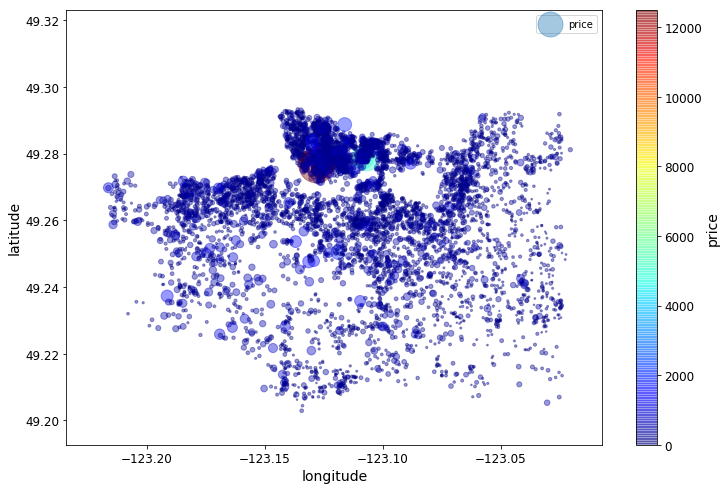

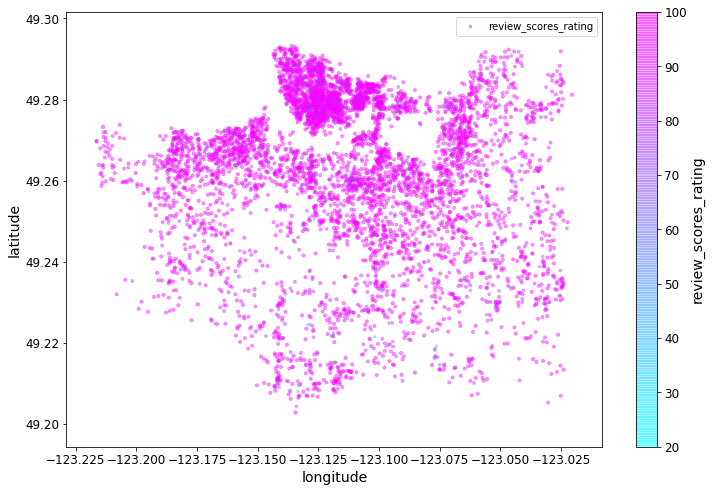

In [28]:
#Plot price on their corresponding longitude and latitude [2]

airbnb_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=airbnb_data["price"]/10, label="price", figsize=(12,8),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

#Plot reviews on their corresponding longitude and latitude

airbnb_data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=airbnb_data["review_scores_rating"]/10, label="review_scores_rating", figsize=(12,8),
    c="review_scores_rating", cmap=plt.get_cmap("cool"), colorbar=True,
    sharex=False)
plt.legend()
plt.show()

** Looking at the price map shows few important points:**
1. The distribution of Airbnb listings are denser in downtown area.
2. Outside of downtown area, Kitsilano beach has the highest density of listings followed by East side.
3. South Vancouver has the lowest density of Airbnb listings.
4. Most of listings are in the range of \$0.0 to \$1500. there are few listings with extreme price values.
5. It is best to only take the data whose price are less than $700.
6. It is not obvious from the two plots above that whether the expensive listings have a high review. We can evaluate this hypothesis by a scatter plot of price and review rating.

In [29]:
number_outlier = len(airbnb_data[airbnb_data['price'] > 700])
price_outlier = len(airbnb_data[airbnb_data['price'] > 700]) / airbnb_data.shape[0] * 100
print('There are {} instances of outlier in the price column. They make {:.2} % of the whole column.'.format(number_outlier, price_outlier))

There are 67 instances of outlier in the price column. They make 1.0 % of the whole column.


In [30]:
# Querying only the rows with a price less than $700.
airbnb_data = airbnb_data.query('price <= 700')

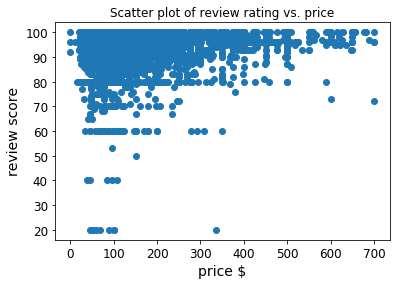

In [31]:
# Scatter plot of review rating versus price
plt.scatter(airbnb_data['price'],airbnb_data['review_scores_rating'])
plt.xlabel('price $')
plt.ylabel('review score')
plt.title('Scatter plot of review rating vs. price')
plt.show()


> It seems that a high price does not lead to a high review score. There many listings with a price in the range \$100 - $300 with a very high review score. Also, there are some expensive listings with a low review rating. This answers the third questions that we asked.

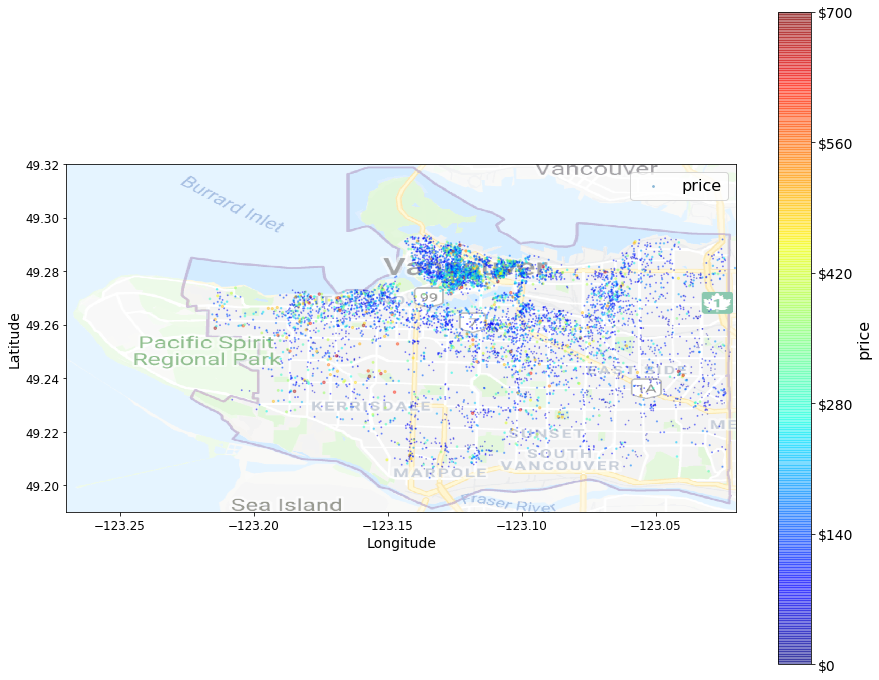

In [35]:
#Plot price on their corresponding longitude and latitude [2]
import matplotlib.image as mpimg
vancouver_img=mpimg.imread('/Users/atahmasb/Downloads/aa.png')

ax = airbnb_data.plot(kind="scatter", x="longitude", y="latitude", figsize=(15,12),
                       s=airbnb_data['price']/100, label="price",
                       c="price", cmap=plt.get_cmap("jet"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(vancouver_img, extent=[-123.27, -123.02, 49.19, 49.32], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = airbnb_data["price"]
tick_values = np.linspace(prices.min(), prices.max(), 6)
cbar = plt.colorbar()
cbar.ax.set_yticklabels(["$%d"%v for v in tick_values], fontsize=14)
cbar.set_label('price', fontsize=16)

plt.legend(fontsize=16)

plt.show()

## 4. Data preprocessing and feature engineering

In [36]:
#Remove these columns as they are not needed for our model
airbnb_data.drop(columns=['id', 'latitude', 'longitude' ], inplace=True)

**Feature engineering**

In [37]:
#Create a new feature by adding number of bathrooms, bedrooms, and beds 
airbnb_data['bed_bath_bathroom'] = airbnb_data['bathrooms'] + airbnb_data['bedrooms'] + airbnb_data['beds']

**Feature scaling:** We have two options: (1) minmaxscaler and (2) StandardScaler. We choose the later one as it is less susceptible to outliers in the data in case they have not been caught.

In [38]:
#Create a pipeline for feature scaling
scl_pipeline = Pipeline([
        ('std_scaler', StandardScaler()),
    ])

In [39]:
X = scl_pipeline.fit_transform(airbnb_data.drop(columns=['price']))

**Creating train and test sets**

In [40]:
# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, airbnb_data['price'], test_size=0.2, random_state=42)

## 5. Model training and model selection
Here we test three models:
1. Linear model
2. Decision Tree
3. Random Forest

We measure each model's room mean square error (RMSE). Then we perform a 10 fold cross validation to see which model would perform better on unseen data.

**Linear regression model**

In [41]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# let's try the model on a few training instances
some_data = X_train[:5]
some_labels = y_train[:5]


print("Predictions:", lin_reg.predict(some_data))

Predictions: [106.08575439 107.76153564 146.25372314  79.25762939  62.63653564]


Compare against the actual values:

In [43]:
print("Labels:", list(some_labels))

Labels: [110.0, 60.0, 185.0, 69.0, 54.0]


Not perfect but not bad as well!

In [44]:
airbnb_predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, airbnb_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse
print('Linear model RMSE: {:.4}'.format(lin_rmse))

Linear model RMSE: 67.5


** Decision Tree model**

In [45]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [46]:
airbnb_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, airbnb_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse
print('Decision Tree model RMSE: {:.4}'.format(tree_rmse))

Decision Tree model RMSE: 0.0


>It seems the decision tree model overfits badly.

**Random Forest model**

In [47]:
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [48]:
airbnb_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, airbnb_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse
print('Random Forest model RMSE: {:.4}'.format(forest_rmse))

Random Forest model RMSE: 29.47


In [49]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation:", scores.std())


In [50]:
lin_scores = cross_val_score(lin_reg, X_train, y_train,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [7.84739387e+13 3.61356535e+14 6.57171329e+01 7.48244705e+01
 6.46774429e+01 7.16103397e+01 3.11423898e+14 7.76390928e+01
 7.09418299e+01 8.68589103e+13]
Mean:  83811328206801.47
Standard deviation: 130775621473179.34


In [51]:
tree_scores = cross_val_score(tree_reg, X_train, y_train,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [ 96.28076794 106.41249742  96.75274734  99.42589121  94.9325044
  99.78424765 101.15584467 107.31076916  97.43481021  91.36026185]
Mean:  99.08503418567383
Standard deviation: 4.681774172206163


In [52]:
forest_scores = cross_val_score(forest_reg, X_train, y_train,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [69.45819197 70.74351061 68.73878532 74.41403357 64.09755433 67.71576249
 74.84060141 75.16368464 72.92727074 67.71509975]
Mean:  70.58144948393218
Standard deviation: 3.499731902070408


> As shown above during training each model, the Decision Tree provides the lowest error. However, after cross validation, the Random Forest model generates the lowest error on average which makes it the best model out of the three tested ones.

## 6. Fine tuning the model

Now we use the Grid Search CV to find the optimal parameters of the Random Forest model.

In [53]:
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

The best hyperparameter combination found:

In [54]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

In [55]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=8, max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=30, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

Let's look at the score of each hyperparameter combination tested during the grid search:

In [56]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

90.45825094463756 {'max_features': 2, 'n_estimators': 3}
78.72956371844508 {'max_features': 2, 'n_estimators': 10}
76.48097429598599 {'max_features': 2, 'n_estimators': 30}
87.65093235331732 {'max_features': 4, 'n_estimators': 3}
76.6898024240823 {'max_features': 4, 'n_estimators': 10}
74.0854465689788 {'max_features': 4, 'n_estimators': 30}
83.59713269485997 {'max_features': 6, 'n_estimators': 3}
74.52472984925998 {'max_features': 6, 'n_estimators': 10}
71.46158167663313 {'max_features': 6, 'n_estimators': 30}
83.67830871486815 {'max_features': 8, 'n_estimators': 3}
73.95243424930091 {'max_features': 8, 'n_estimators': 10}
71.00618593466751 {'max_features': 8, 'n_estimators': 30}
87.70882378851375 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
78.01446715386959 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
84.60185145015858 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
74.71001729244209 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}


In [57]:
pd.DataFrame(grid_search.cv_results_).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_n_estimators,param_bootstrap,params,split0_test_score,split1_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.014713,0.003625,0.001762,0.000281,2,3,NaN,"{'max_features': 2, 'n_estimators': 3}",-8051.984532,-8568.129103,...,-8182.695164,430.185725,18,-2187.795251,-2071.954024,-2125.139318,-2032.879814,-2083.202954,-2100.194272,52.751568
1,0.034606,0.000095,0.003645,0.000053,2,10,NaN,"{'max_features': 2, 'n_estimators': 10}",-6440.115225,-6291.430795,...,-6198.344203,536.873053,11,-1152.973584,-1192.992855,-1180.676355,-1071.673149,-1064.101131,-1132.483415,54.365107
2,0.098805,0.000641,0.009518,0.000165,2,30,NaN,"{'max_features': 2, 'n_estimators': 30}",-5957.530139,-5896.050603,...,-5849.339429,445.757821,8,-900.590593,-896.047992,-902.444478,-870.502547,-888.843539,-891.685830,11.583453
3,0.013757,0.000181,0.001600,0.000044,4,3,NaN,"{'max_features': 4, 'n_estimators': 3}",-7569.834967,-7284.990186,...,-7682.685942,384.895520,16,-1923.532903,-1878.776878,-2026.468032,-1766.441880,-1989.656992,-1916.975337,91.031554
4,0.040026,0.000457,0.003612,0.000058,4,10,NaN,"{'max_features': 4, 'n_estimators': 10}",-5889.962539,-5813.898950,...,-5881.325796,414.811443,9,-1056.583734,-1084.991028,-1088.352967,-963.744667,-1031.839389,-1045.102357,45.581846


## 6. Evaluate the model on test set

In [58]:
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [59]:
final_rmse

69.60712452246472

**Confidence interval for test set RMSE**

In [60]:
confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2
mean = squared_errors.mean()
m = len(squared_errors)

np.sqrt(stats.t.interval(confidence, m - 1,
                         loc=np.mean(squared_errors),
                         scale=stats.sem(squared_errors)))

array([64.22628923, 74.60085348])

## 7. Results and discussion

**Feature importance**

In [61]:
feature_importances = grid_search.best_estimator_.feature_importances_
attributes = airbnb_data.drop(columns='price').columns
features = sorted(zip(feature_importances, attributes), reverse=True)

In [62]:
#Create list of all attributes and their coefficient for plotting purposes
attribute = []
coefficient = []
for feature in features:
    attribute.append(feature[1]) 
    coefficient.append(feature[0])



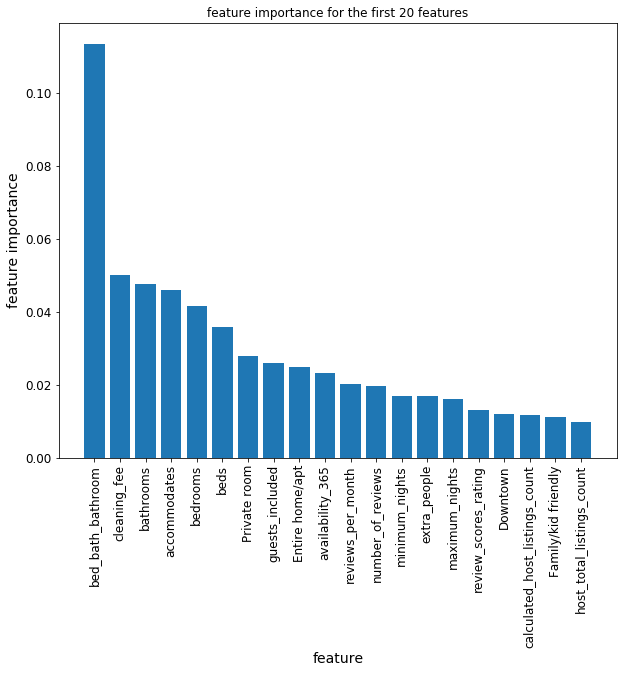

In [63]:
plt.figure(figsize=(10,8))
plt.bar(attribute[:20], height=coefficient[:20])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the first 20 features')
plt.show()

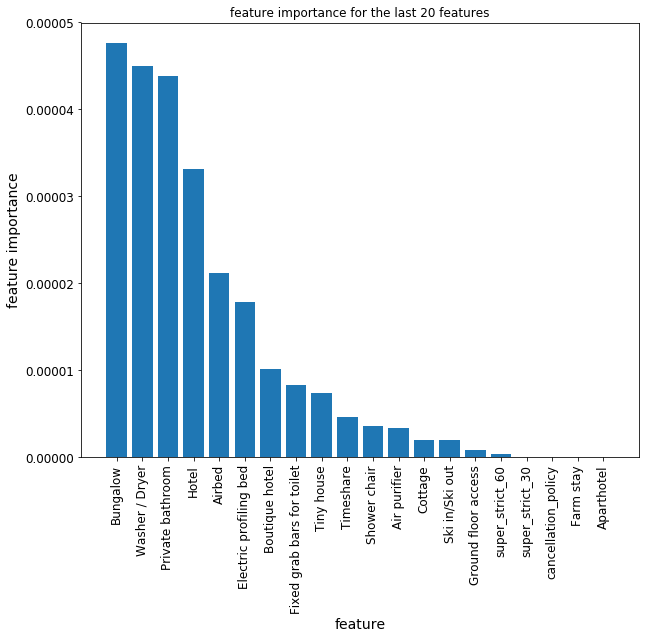

In [64]:
plt.figure(figsize=(10,8))
plt.bar(attribute[-20:], height=coefficient[-20:])
plt.xticks(rotation=90)
plt.xlabel('feature')
plt.ylabel('feature importance')
plt.title('feature importance for the last 20 features')
plt.show()

Here are our conclusions from the feature importance bar plots:
1. number of beds, baths, and bedrooms are the most important features that determine the cost. This is not surprising! we could expect that an Airbnb price can be affected significantly by the number of beds and bath.
2. There are other factors which their effects on the price was predictable such as: accommodates, private room, guest_included, entire home/apartment.
3. Surprisingly, availability in a year and total host listing are among the important features.
4. Among all the locations, we only have downtown in the top 20 features which makes sense. Normally, prices are higher in the downtown area of Vancouver.

We should note that the feature importance only tells us which features are important in prediction of an Airbnb price. It does not tell us anything about how variation of a feature varies the price. To study the sensitivity of price to each feature, one need to generate **partial dependence** plots. Unfortunately, in scikit-learn, this plot is only available in **GradientBoostingRegressor** module.

**Important amenities**

In [65]:
#Create list of all amenities and their coefficient for plotting purposes
amenity= []
amn_coef = []
for feature in features:
    if feature[1] in all_amenities:
        amenity.append(feature[1])
        amn_coef.append(feature[0])


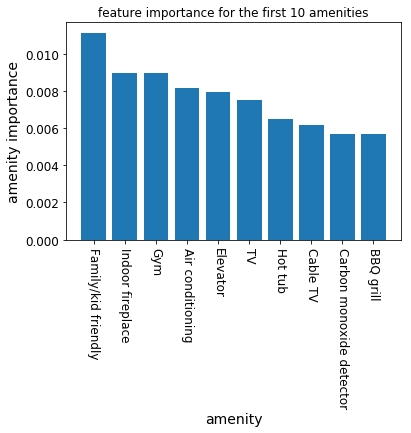

In [66]:
plt.figure(figsize=(6,4))
plt.bar(amenity[:10], height=amn_coef[:10])
plt.xticks(rotation=-90)
plt.xlabel('amenity')
plt.ylabel('amenity importance')
plt.title('feature importance for the first 10 amenities')
plt.show()

These are my observations and explanation for the bar plot of the first 10 important amenities:
1. Renting a Family/kid friendly Airbnb is an important concern for most of families. Therefore, it makes sense that these features affect the price significantly compared to the listings which do not have this feature.
2. Indore fireplace is an extra cost for the host of an Airbnb place. So, having this feature normally increases the price. The same logic will apply to the rest of the features in the first 10 important features except TV.
3. To support my point, we can see that Wi-Fi is not among the top 10. It is actually 68 in 123 available amenities. That's because almost all homes have Wi-Fi nowadays! It was expected that Wi-Fi would not affect the price significantly.